1. Importing libraries first

In [8]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

2. Time to load the data into the SQLite3.

In [13]:
DB_PATH = "studentJourney.db"
DATA_DIR = "Data"

# Connect (creates file if not exists)
conn = sqlite3.connect(DB_PATH)

# Optionally, create schema explicitly
with open("schema.sql", "r", encoding="utf-8") as f:
    ddl = f.read()
conn.executescript(ddl)

tables = [
    "Department_Information",
    "Employee_Information",
    "Student_Counceling_Information",
    "Student_Performance_Data"
]

# Load each CSV; replace tables if they exist
for t in tables:
    csv_path = os.path.join(DATA_DIR, f"{t}.csv")
    df = pd.read_csv(csv_path)
    df.to_sql(t, conn, if_exists="replace", index=False)

# Show tables in DB
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,Student_Counseling_Information
1,Department_Information
2,Employee_Information
3,Student_Counceling_Information
4,Student_Performance_Data


In [13]:
reports = {}
#connection to database 
conn = sqlite3.connect("studentJourney.db")
#time to dig department information
dept = pd.read_sql_query("SELECT * FROM Department_Information", conn)

reports["dept_missing"] = dept[dept.isna().any(axis=1)]
reports["dept_duplicate_id"] = dept[dept.duplicated(subset=["Department_ID"], keep=False)]
reports["dept_duplicate_name"] = dept[dept.duplicated(subset=["Department_Name"], keep=False)]
reports["dept_invalid_doe"] = dept[dept["DOE"].apply(lambda x: pd.isna(x) or (str(x).strip()=='' ) or (pd.to_numeric(x, errors='coerce') is not None and pd.to_numeric(x, errors='coerce') < 1900))]

#student council infromation start
coun = pd.read_sql_query("SELECT * FROM Student_Counseling_Information", conn)
reports["coun_missing"] = coun[coun.isna().any(axis=1)]

#according to asgn reqmts does department exist?
dept_ids = set(dept["Department_ID"].dropna().astype(str))
reports["coun_bad_admission"] = coun[~coun["Department_Admission"].astype(str).isin(dept_ids)]

#get student performance data
perf = pd.read_sql_query("SELECT * FROM Student_Performance_Data", conn)

reports["perf_missing"] = perf[perf.isna().any(axis=1)]

# Invalid Marks
reports["perf_bad_marks"] = perf[~perf["Marks"].between(0,100)]
# Invalid Effort
reports["perf_bad_effort"] = perf[perf["Effort_Hours"] < 0]

# Duplicate (Student_ID, Paper_ID)
reports["perf_dup_pair"] = perf[perf.duplicated(subset=["Student_ID","Paper_ID"], keep=False)]

# --- Clean performance (drop invalids & missing) ---
perf_clean = perf.copy()
perf_clean = perf_clean.dropna()
perf_clean = perf_clean[perf_clean["Marks"].between(0,100)]
perf_clean = perf_clean[perf_clean["Effort_Hours"] >= 0]

# Remove duplicates: keep first
perf_clean = perf_clean.drop_duplicates(subset=["Student_ID","Paper_ID"], keep="first")

# Save cleaned table
perf_clean.to_sql("Cleaned_Performance", conn, if_exists="replace", index=False)

dept["Department_ID"] = dept["Department_ID"].astype(str).str.strip().str.upper()
coun["Department_Admission"] = coun["Department_Admission"].astype(str).str.strip().str.upper()
# Also join for analysis (student + dept + perf)
join_sql = '''
SELECT p.*, s.Department_Admission AS Department_ID
FROM Cleaned_Performance p
LEFT JOIN Student_Counseling_Information s
  ON p.Student_ID = s.Student_ID
'''
clean_df = pd.read_sql_query(join_sql, conn)

# Attach department names
clean_df = clean_df.merge(
    dept[["Department_ID","Department_Name"]],
    how="left", on="Department_ID"
)

clean_df.head()

,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours,Department_ID,Department_Name
0,SID20131143,Sem_1,SEMI0012995,Paper 1,44.0,5.0,None,NaN
1,SID20131143,Sem_1,SEMI0015183,Paper 2,74.0,8.0,None,NaN
2,SID20131143,Sem_1,SEMI0018371,Paper 3,80.0,8.0,None,NaN
3,SID20131143,Sem_1,SEMI0015910,Paper 4,44.0,5.0,None,NaN
4,SID20131143,Sem_1,SEMI0016208,Paper 5,95.0,12.0,None,NaN


In [15]:
for k, v in reports.items():
    print(f"\n==== {k} ====")
    if v.empty:
        print("No exceptions.")
    else:
        display(v.head(20))


==== dept_missing ====


,Department_ID,Department_Name,DOE
21,IDEPT5528,Sanitation and Digital Gaming,None
39,IDEPT9009,Laser Technology Enhancements,None



==== dept_duplicate_id ====


,Department_ID,Department_Name,DOE
1,IDEPT5528,Biosciences and Bioengineering,6/28/1943
11,IDEPT1825,Mechanical Engineering,9/21/1971
15,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982
21,IDEPT5528,Sanitation and Digital Gaming,None
24,IDEPT7005,Centre of Studies in Resources Engineering (CSRE),8/22/1966
25,IDEPT7005,Centre of Studies in Craft Engineering (CSCE),8/22/1966
27,IDEPT9009,Centre for the Study of Ecology in Mars,7/9/2025
35,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982
39,IDEPT9009,Laser Technology Enhancements,None
45,IDEPT1825,Materials Strength Testing,9/21/1971



==== dept_duplicate_name ====


,Department_ID,Department_Name,DOE
15,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982
35,IDEPT3868,Center for Learning and Teaching (PPCCLT),3/26/1982



==== dept_invalid_doe ====


,Department_ID,Department_Name,DOE
21,IDEPT5528,Sanitation and Digital Gaming,None
39,IDEPT9009,Laser Technology Enhancements,None



==== coun_missing ====
No exceptions.

==== coun_bad_admission ====
No exceptions.

==== perf_missing ====


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours
125,SID20131171,Sem_3,SEMI0031818,None,87.0,11.0
172218,SID20179280,Sem_4,SEMI0044518,Paper 6,NaN,NaN
209593,SID20189989,Sem_6,SEMI0064181,Paper 4,NaN,6.0



==== perf_bad_marks ====


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours
328,SID20131189,Sem_1,SEMI0015910,Paper 4,-49.0,0.0
414,SID20131191,Sem_5,SEMI0055015,Paper 6,207.0,14.0
551,SID20131231,Sem_1,SEMI0016208,Paper 5,-100.0,14.0
840,SID20131303,Sem_3,SEMI0031818,Paper 4,140.0,14.0
172218,SID20179280,Sem_4,SEMI0044518,Paper 6,NaN,NaN
181488,SID20182774,Sem_8,SEMI0086600,Paper 6,999.0,5.0
209593,SID20189989,Sem_6,SEMI0064181,Paper 4,NaN,6.0



==== perf_bad_effort ====


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours
59635,SID20147406,Sem_6,SEMI0067259,Paper 2,78.0,-3.0



==== perf_dup_pair ====
No exceptions.


,Student_ID,Semster_Name,Paper_ID,Paper_Name,Marks,Effort_Hours,Department_ID,Department_Name
count,209601,209601,209601,209601,209601.000000,209601.000000,0,0
unique,3819,8,56,7,NaN,NaN,0,0
top,SID20174212,Sem_7,SEMI0071868,Paper 6,NaN,NaN,NaN,NaN
freq,56,26236,3761,29972,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,69.589372,8.085233,NaN,NaN
std,NaN,NaN,NaN,NaN,18.098372,2.797781,NaN,NaN
min,NaN,NaN,NaN,NaN,19.000000,2.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,54.000000,6.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,70.000000,7.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,85.000000,10.000000,NaN,NaN


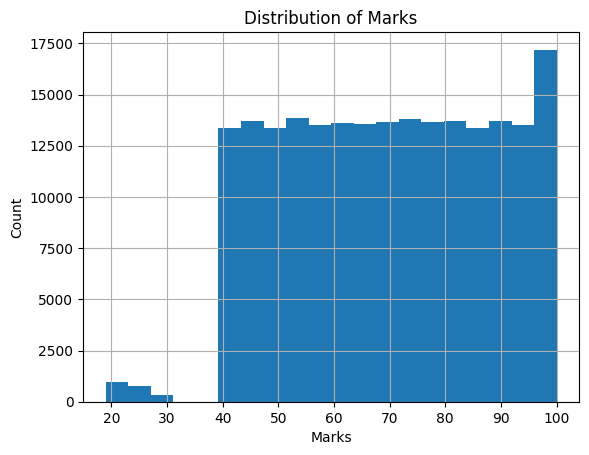

<Figure size 640x480 with 0 Axes>

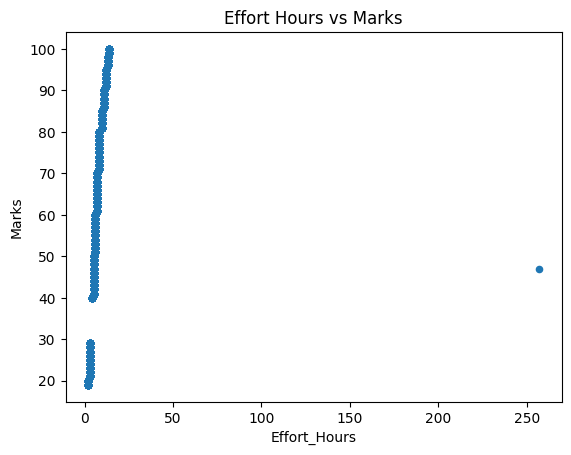

Series([], Name: Marks, dtype: float64)

In [17]:
# Summary stats
display(clean_df.describe(include="all"))

# Marks Distribution
plt.figure()
clean_df["Marks"].dropna().hist(bins=20)
plt.title("Distribution of Marks")
plt.xlabel("Marks")
plt.ylabel("Count")
plt.show()

# Effort vs Marks scatter
plt.figure()
clean_df.plot.scatter(x="Effort_Hours", y="Marks")
plt.title("Effort Hours vs Marks")
plt.show()

# Avg marks by department (if available)
if "Department_Name" in clean_df.columns:
    avg_dept = clean_df.groupby("Department_Name")["Marks"].mean().sort_values(ascending=False)
    display(avg_dept.head(20))

In [10]:
TARGET_STUDENTS = ["SID20131151", "SID20149500", "SID20182516"]

def predict_for_student(df, student_id, effort_hours=10):
    s = df[df["Student_ID"] == student_id].dropna(subset=["Effort_Hours","Marks"])
    if len(s) < 2:
        return {"Student_ID": student_id, "Predicted": None, "Note": "Not enough data points"}
    X = s[["Effort_Hours"]].values
    y = s["Marks"].values
    model = LinearRegression()
    model.fit(X, y)
    pred = model.predict(np.array([[effort_hours]]))[0]
    return {"Student_ID": student_id, "Predicted": float(round(pred, 2))}

results = [predict_for_student(clean_df, sid, 10) for sid in TARGET_STUDENTS]
res_df = pd.DataFrame(results)

# Attach department info if available
dept_map = clean_df.groupby("Student_ID")["Department_ID"].agg(lambda x: x.dropna().iloc[0] if len(x.dropna()) else None)
dept_name_map = clean_df.groupby("Student_ID")["Department_Name"].agg(lambda x: x.dropna().iloc[0] if len(x.dropna()) else None)

res_df["Department_ID"] = res_df["Student_ID"].map(dept_map.to_dict())
res_df["Department_Name"] = res_df["Student_ID"].map(dept_name_map.to_dict())
display(res_df)

,Student_ID,Predicted,Department_ID,Department_Name
0,SID20131151,81.92,None,None
1,SID20149500,82.25,None,None
2,SID20182516,82.17,None,None


In [11]:
import os, pandas as pd

try:
    REPORT_DIR = "reports"
    os.makedirs(REPORT_DIR, exist_ok=True)
    summary_rows = []
    if 'reports' in globals() and isinstance(reports, dict):
        for name, df in reports.items():
            if hasattr(df, "to_csv"):
                out_path = os.path.join(REPORT_DIR, f"{name}.csv")
                df.to_csv(out_path, index=False)
                summary_rows.append({"report_name": name, "rows": len(df), "path": out_path})
            else:
                summary_rows.append({"report_name": name, "rows": None, "path": None})
        report_summary = pd.DataFrame(summary_rows)
        display(report_summary)
        print("Saved individual exception CSVs to ./reports")
    else:
        print("No 'reports' dictionary found. Run the validation/ETL cells first.")
except Exception as e:
    print("Could not export reports:", e)

,report_name,rows,path
0,dept_missing,2,reports\dept_missing.csv
1,dept_duplicate_id,10,reports\dept_duplicate_id.csv
2,dept_duplicate_name,2,reports\dept_duplicate_name.csv
3,dept_invalid_doe,2,reports\dept_invalid_doe.csv
4,coun_missing,0,reports\coun_missing.csv
5,coun_bad_admission,0,reports\coun_bad_admission.csv
6,perf_missing,3,reports\perf_missing.csv
7,perf_bad_marks,7,reports\perf_bad_marks.csv
8,perf_bad_effort,1,reports\perf_bad_effort.csv
9,perf_dup_pair,0,reports\perf_dup_pair.csv


Saved individual exception CSVs to ./reports


In [12]:
import os, pandas as pd

try:
    if 'res_df' in globals():
        final_cols = ["Student_ID", "Department_ID", "Department_Name", "Predicted"]
        # Graceful reindex if some columns are missing
        cols = [c for c in final_cols if c in res_df.columns]
        final_results = res_df.reindex(columns=cols)
        display(final_results)
        os.makedirs("outputs", exist_ok=True)
        out_path = "outputs/predicted_next_marks.csv"
        final_results.to_csv(out_path, index=False)
        print("Saved:", out_path)
    else:
        print("No 'res_df' found. Run the predictive modeling cell first.")
except Exception as e:
    print("Could not export predictions:", e)

,Student_ID,Department_ID,Department_Name,Predicted
0,SID20131151,None,None,81.92
1,SID20149500,None,None,82.25
2,SID20182516,None,None,82.17


Saved: outputs/predicted_next_marks.csv
